Calculate when models reach 2 or 3 degrees global warming level for ASCE 7

global mean temperatures calculated separately and concatenated for NACORDEX Driving GCMs for RCP4.5 and RCP8.5. Starting all calculations in 1995 for consistency.

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import glob
import os
from os.path import expanduser, join

import numpy as np
import pandas as pd
import xarray as xr

In [3]:
dir = "/glade/u/home/maritye/PROGS/Icing/GWL/"

In [4]:
model = ['CanESM2', 'GFDL-ESM2M', 'HadGEM2-ES', 'MPI-ESM-LR', 'MPI-ESM-MR']
scen = ['rcp45', 'rcp85']

In [5]:
time = np.arange(1995,2101,1)

In [32]:
delta_gmtas = xr.Dataset(data_vars=dict(
        temperature=(["model", "scenario", "time"]),
        conf95=(["model", "scenario", "time"]),
        conf5=(["model", "scenario", "time"]),
    ),
    coords=dict(
        scenario=scen,
        model=model,
        time=time,
    ),
    attrs=dict(description="Ensemble mean global mean temperature rise")
                        )

In [10]:
for mod in model:
    for iscen in scen:
# which models
        sim_files = sorted(glob.glob(join(dir, "tas_" + mod + "_*_" + iscen + "-globalmeantemp_1995-2100.nc")))
#open data
        ds = xr.open_mfdataset(
                sim_files,
                combine="nested",
                concat_dim="member",
            )
# increase above 1995-2014 mean, assuming = 0.85C
        difftemp = ds.tas - ds.tas.isel(time=0)

        ensmean = difftemp.mean(dim='member')
        delta_gmtas[mod,iscen,] = ensmean
        
        ens_stdev = difftemp.std(dim='member')

        ensconf5[] = ensmean - ens_stdev*1.64
        ensconf95[] = ensmean + ens_stdev*1.64
        

CanESM2 rcp45
CanESM2 rcp85
GFDL-ESM2M rcp45
GFDL-ESM2M rcp85
HadGEM2-ES rcp45
HadGEM2-ES rcp85
MPI-ESM-LR rcp45
MPI-ESM-LR rcp85
MPI-ESM-MR rcp45
MPI-ESM-MR rcp85


# Comparing scenarios

In [41]:
# Compare 2 degrees using all data vs. just one scenario
sim_files = sorted(glob.glob(join(dir, 'tas_' + model[4] + '*')))

ds = xr.open_mfdataset(sim_files,
                       combine='nested',
                       concat_dim='member')

In [42]:
# calculate the timeseries of differences from 1995, assuming = 0.85C
difftemp = ds.tas - ds.tas.isel(time=0)

In [43]:
difftemp = difftemp.compute()

### Plot

In [9]:
import matplotlib.pyplot as plt

In [10]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

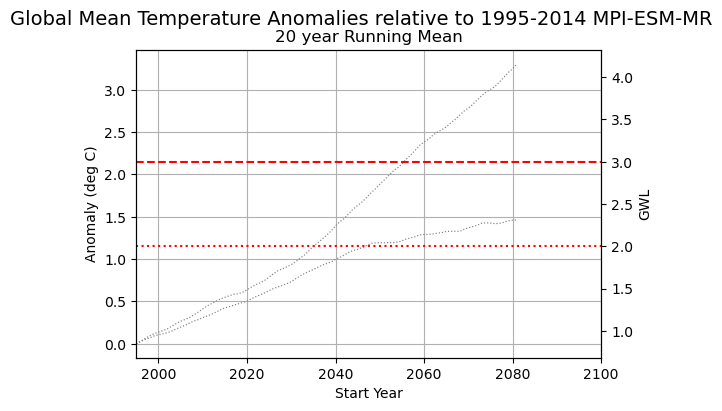

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

t = difftemp.time.dt.year

# plot cesm2 cmip6 lens
for i in range(len(ds.member)):
    ax.plot(t, difftemp.isel(member=i), linestyle=":", color="grey", linewidth=0.85)


#ax.plot(t, ensmean)
#ax.plot(t, ens5, color = 'red', linestyle="--", linewidth=0.75)
#ax.plot(t, ens95, color='red', linestyle='--', linewidth=0.75)

ax.set_xlim(1995, 2100)
ax.set_xlabel("Start Year")
ax.set_ylabel("Anomaly (deg C)")
ax.set_title("20 year Running Mean")
ax.grid(True)

ax2 = ax.twinx()
mn, mx = ax.get_ylim()
ax2.set_ylim(mn+0.85, mx+.85)
ax2.set_ylabel('GWL')

ax.axhline(y=1.15, color="red", linestyle=":")
ax.axhline(y=2.15, color="red", linestyle="--")

fig.suptitle("Global Mean Temperature Anomalies relative to 1995-2014 MPI-ESM-MR", fontsize=14)
"""
custom_lines = [
    Line2D([0], [0], color="black", linestyle="-"),
    Line2D([0], [0], color="red", linestyle="--"),
]

plt.legend(
    custom_lines,
    ("Model Mean", "Confidence"),
    fontsize="medium",
    ncols=2,
    loc="center",
    bbox_to_anchor=(0.5, -0.25),
)
"""
plt.savefig(
    "/glade/u/home/maritye/Plots/Icing/MPI-ESM-MR_globalwarminglevels_1850-2100.png", dpi=300
)
plt.show()

# Get model dates

In [76]:
gwl = xr.Dataset(data_vars=dict(
        early2_yr =(['model', 'scenario']),
        late2_yr =(['model', 'scenario']),
        gwl2_yr =(['model', 'scenario']),
        early3_yr =(['model', 'scenario']),
        late3_yr =(['model', 'scenario']),
        gwl3_yr =(['model', 'scenario']),
    
    ),
    coords=dict(
        scenario=scen,
        model=model,
    ),
    attrs=dict(description="Years when GWL reached")
                )

In [108]:
for imod in model:
    for isc in scen:

        sim_files = sorted(glob.glob(join(dir, "*" + imod +'*' + isc +'*')))

        ds = xr.open_mfdataset(
            sim_files,
            combine="nested",
            concat_dim="member",
        )

        # calculate the timeseries of differences from 1995, assuming = 0.85C
        difftemp = ds.tas - ds.tas.isel(time=0)
        ensmean = difftemp.mean(dim='member')
        ens_stdev = difftemp.std(dim='member')

        ens95 = ensmean + ens_stdev*1.64
        ens5 = ensmean - ens_stdev*1.64

        ensmean = ensmean.compute()
        ens95 = ens95.compute()
        ens5 = ens5.compute()

        if(ensmean.max()>1.15):

            early2_yr = ens95.where(ens95>1.15, drop=True).time[0]
            print(imod, isc, " Early = ",early2_yr.values)
            
            late2_yr = ens5.where(ens5>1.15, drop=True).time[0]
            print(imod, isc, " Late = ",late2_yr.values)
            
            gwl2_yr = ensmean.where(ensmean>1.15, drop=True).time[0]
            print(imod, isc, " Mean = ",gwl2_yr.values)
        else:
            print(imod, isc, ' GWL2 Not Reached')

        if(ensmean.max()>2.15):

            early3_yr = ens95.where(ens95>2.15, drop=True).time[0]
            print(imod, isc, " Early = ",early3_yr.values)

            if(ens5.max() > 2.15):
                late3_yr = ens5.where(ens5>2.15, drop=True).time[0]
                print(imod, isc, " Late = ",late3_yr.values)
            else:
                print(imod, isc, ' Late3 not reached')
                
            gwl3_yr = ensmean.where(ensmean>2.15, drop=True).time[0]
            print(imod, isc, " Mean = ", gwl3_yr.values)

        else:
            print(imod, isc, ' GWL3 Not Reached')


CanESM2 rcp45  Early =  2029-01-01 00:00:00
CanESM2 rcp45  Late =  2032-01-01 00:00:00
CanESM2 rcp45  Mean =  2031-01-01 00:00:00
CanESM2 rcp45  GWL3 Not Reached
CanESM2 rcp85  Early =  2023-01-01 00:00:00
CanESM2 rcp85  Late =  2025-01-01 00:00:00
CanESM2 rcp85  Mean =  2024-01-01 00:00:00
CanESM2 rcp85  Early =  2043-01-01 00:00:00
CanESM2 rcp85  Late =  2046-01-01 00:00:00
CanESM2 rcp85  Mean =  2045-01-01 00:00:00
GFDL-ESM2M rcp45  GWL2 Not Reached
GFDL-ESM2M rcp45  GWL3 Not Reached
GFDL-ESM2M rcp85  Early =  2042-01-01 00:00:00
GFDL-ESM2M rcp85  Late =  2042-01-01 00:00:00
GFDL-ESM2M rcp85  Mean =  2042-01-01 00:00:00
GFDL-ESM2M rcp85  Early =  2072-01-01 00:00:00
GFDL-ESM2M rcp85  Late =  2072-01-01 00:00:00
GFDL-ESM2M rcp85  Mean =  2072-01-01 00:00:00
HadGEM2-ES rcp45  Early =  2028-01-01 00:00:00
HadGEM2-ES rcp45  Late =  2036-01-01 00:00:00
HadGEM2-ES rcp45  Mean =  2031-01-01 00:00:00
HadGEM2-ES rcp45  Early =  2064-01-01 00:00:00
HadGEM2-ES rcp45  Late3 not reached
HadGEM2-

From Tebaldi: 5 %–95 % ranges, which are obtained assuming a normal distribution as 1.64σ, where σ is the intermodel standard deviation of the smoothed trajectories, computed for each year

Look at data from TNC project

In [109]:
cmip5 = xr.open_dataset('/glade/derecho/scratch/jsallen/tnc_2025/warming_levels/cmip5.global.warming.levels.r1i1p1.nc')

In [116]:
cmip5.sel(warming_level='2.0').models.values

array(['HadGEM2-ES', 'EC-EARTH', 'MPI-ESM-LR', 'GFDL-ESM2M', 'BNU-ESM',
       'CanESM2', 'ACCESS1-0', 'ACCESS1-3', 'FIO-ESM', 'inmcm4',
       'IPSL-CM5B-LR', 'FGOALS-s2', 'MIROC5', 'MIROC-ESM-CHEM',
       'MIROC-ESM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'MRI-ESM1',
       'NorESM1-M', 'HadGEM2-AO'], dtype='<U14')

In [118]:
cmip5.sel(warming_level='2.0').year.values

array([2036, 2039, 2038, 2052, 2023, 2027, 2041, 2043, 2044, 2058, 2038,
       2011, 2051, 2031, 2031, 2038, 2040, 2053, 2051, 2049, 2045])

In [123]:
cmip5.sel(warming_level='3.0').year.values

array([2055, 2062, 2062, 2082, 2046, 2050, 2061, 2062, 2069, 2084, 2062,
       2037, 2075, 2051, 2053, 2062, 2061, 2077, 2074, 2073, 2062])